## GLACIER AREA CALCULATOR ### 

This project will primarily use the USGS Python Package to identify, download and present Landsat imagery from 1985, 2005 and 2025 across several glacier mountain ranges across the world. 
The mountain ranges will include:
- Kenai Mountains (Alaska)
- Swiss Alps
- *Insert Greenland/Himalayas maybe?*
This script will download and present the images in False Colour Composite, then will generate a classification to identify the ice area on the images and this classification will be used in each image to calculate the change in glacier area across glaciated areas on a global scale.

##TO DO LIST FOR THE STUDY## 


----KENAI MOUNTAINS----
- Identify Landsat information on the USGS EE site and get the correct WRS path, etc.
- Download Landsat Images for Kenai Mountains first
- Clasification
- Area change calculation
- See if you can edit the image to show only the selected mountain range (Crop Stacked Landsat TIF)
- Maybe include some help() but ask Bob if it is something that is expected or required

----Swiss Alps-----
- Same as above
- Try to select area with Alestchgletscher

----GREENLAND/HIMALAYAS----
- Same as above


---AFTER LANDSAT DONE-----
- Generate a comparison Table/Template for all results acquired
- IF YOU HAVE TIME, maybe do a couple more glacier mountains
- Keep it that the script can be used to generate area as long as the correct info is input (ID, WRS, ETC..)
- Ask if an ArcGIS element is expected for the assignment
- Ask/Check how the how-to-guide is to be formatted (separate word doc in Git Repos/in the README/....
- Check how the final repos is to be submitted



In [86]:
import usgs
from usgs import api
import os
import requests
import tarfile
import rasterio
from rasterio.windows import from_bounds
from shapely.geometry import box
import numpy as np
import matplotlib.pyplot as plt

In [67]:
# Open and read the Username and Api Key/Token for the USGS account
with open('C:/Users/couse/.usgs_user', 'r') as usertext:
    username = usertext.read()
with open('C:/Users/couse/.usgs_token', 'r') as tokentext:
    password = tokentext.read()
    
# Log in using the above information in the script attached below
login = api.login(username, password, save=True)

#The API Key (token) is extracted separately as it will be used in the script to search for and download Landsat imagery
api_key = login['data']
print("Logged in")

Logged in


To identify and search for the required Landsat scenes in this study we are going to use the api.scene_search() function as this will be the primary method for getting the correct images before we download them. Below is some of the information we will need for the search

In [ ]:
help(api.scene_search)

For the scene searches in this study we are going to need the following:
- Dataset ID (dataset)
- Latitude and Longitude (lat and lng)
- Earth Explorer allows us to create a bounding box to get available images that cover those areas (ll and ur - Lower left corner and Upper Right corner for the bounding box respectively)
- Start and End date (start_date and end_date)
- Filters to get the correct images (where) (WRS Path, Cloud Cover, etc.)
- Max Results incase there are multiple available images (max_results)
- The extracted Api key (api_key)

Future adaptations could include filtering image selection based on cloud coverage to ensure that images used are cloud free.

We are going to use dataset_search to identify what Landsat datasets are available and importantly the exact 'dataset' which we will use to download and extract the specific scenes needed for this study

In [ ]:
# Landsat imagery comes from the EarthExplorer dataset (node), we will do a search and print out all Landsat datasets in the Earth Explorer node
satellite_avail = api.dataset_search("landsat", "EE")
for dataset in satellite_avail['data']:
        print(dataset['datasetAlias']) #Prints out names of all available datasets

All available scenes are printed above. In this project we are going to use the 'landsat_tm_c2_l1' (~1985 and ~2004) and the 'landsat_ot_c2_l1' (2024) datasets to acquire imagery of the selected glacier mountainscapes. The next step is to search for the Landsat images that will be used for the study. You can get the Bounding box coordinates and landsat image information on the USGS Earth Explorer website = https://earthexplorer.usgs.gov/. In this study, a set date has been used to get the exact image required, however the date range can be adjusted to get see the available products ether across a range of dates or on different days.

In [ ]:
help(api.scene_search)

In [ ]:
# In this cell we will use the search function to get the product id of the imager used in the study
results = api.scene_search(
    dataset = "landsat_tm_c2_l1", #Landsat dataset used for 1986 image
    lat = 60.09345, # The latitude of the image
    lng = -151.07395, # The longtitude of the image
    ll = {"longitude" : -151.7075, "latitude" : 59.1140}, # The Latitude and Longtitude of the Lower left corner of the Bounding Box in EE
    ur = {"longitude" : -150.1913, "latitude" : 59.9276}, # The Latitude and Longtitude of the Upper Right corner of the Bounding Box in EE
    start_date = "1986-09-11", # The start date of the search range
    end_date = "1986-09-13", # The end date of the search range
    api_key=api_key # The Users Api key
)
#The next lines of script will loop through each 'scene' that appears in the results and will print out the 'entity ID' which will be used in the dataset downlaod.
for scene in results['data']['results']:
    print("The Entity ID of the Landsat scene is",(scene['entityId'])) 

Now that the Entity ID is known we can now download the Band files which we will use to build a false colour composite image of the Kenai Mountains.

In [ ]:
#This cell will provide the different download options for the Landsat dataset
api.dataset_download_options("landsat_tm_c2_l1")                             

In this study we are going to use the 'Landsat Collection 2 Level-1 Product Bundle' to download all the different bands. The product ID code with the downlaod option will be used in the download request to download zip file into the repository.

In [ ]:
help(api.dataset_download_options)

In [8]:
help(api.download_request)

Help on function download_request in module usgs.api:

download_request(dataset, entity_id, product_id, api_key=None)
    This method is used to insert the requested downloads into the download queue
    and returns the available download URLs.



In [59]:
# The below code will download the Landsat Satellite images which we identified in the Scene Search above
# We will use the OS module to create a new folder for the Landsat images to be downloaded into
# The download url returned in the download_request will be used via the requests module
# The images will downloaded as a tar file as this file type is supported by the api

os.makedirs("KenaiMountains1986", exist_ok=True) # This will create a new folder for the Kenai Mountains 1986 images

KM_1986 = api.download_request( # This functions will return the available download urls for the Landsat scene
    dataset="landsat_tm_c2_l1", # Landsat dataset
    entity_id="LT50690181986255XXX05", # Landsat scene ID
    product_id="5e83d0a0f94d7d8d", # Product ID (Landsat Band file)
)

 # The below code will download the Landsat data using the url provided by the download_request function from the EE node
if 'data' in KM_1986 and 'availableDownloads' in KM_1986['data']:
    KM_1986Avail = KM_1986['data']['availableDownloads'] # Identifies if the above Landsat is available to be downloaded
    if KM_1986Avail:
        KM1986downloadurl = KM_1986Avail[0]['url'] # We access the first download url retrieved from download_request
        KM_1986File = os.path.join("KenaiMountains1986", f"LT50690181986255XXX05.tar") # We set a file pathway for the download into the new Kenai Mountains 1986 folder created above
        KM1986url = requests.get(KM1986downloadurl, stream=True) # We use the requests module to request the url stored in the 'KM1986downloadurl' variable
        
        with open(KM_1986File, "wb") as f: # We are telling the code to overwrite or create the file and write it in binary mode to avoid corruption as we are downloading images
            for chunk in KM1986url.iter_content(chunk_size=8192): # To avoid causing issues downloading larger sets of data we download the folder in 8 KB Chunks
                if chunk:
                    f.write(chunk)

# The download may take some time but you will see the download progress in the newly creaated 'KenaiMountains1986' folder (click refresh on the folder)
print("1986 Kenai Mountain images downloaded!") # The text will display whenever the download has been completed

1986 Kenai Mountain images downloaded!


In [61]:
# We will extract the Landsat images from the scene we have just downloaded into the same folder

with tarfile.open("KenaiMountains1986/LT50690181986255XXX05.tar", 'r') as KM1986Tar:
    KM1986Tar.extractall("KenaiMountains1986")

print("Images have been successfully extracted")

Images have been successfully extracted


Now that the images for the 1986 dataset have been downloaded we will build a false colour composite image of the Landsat scene

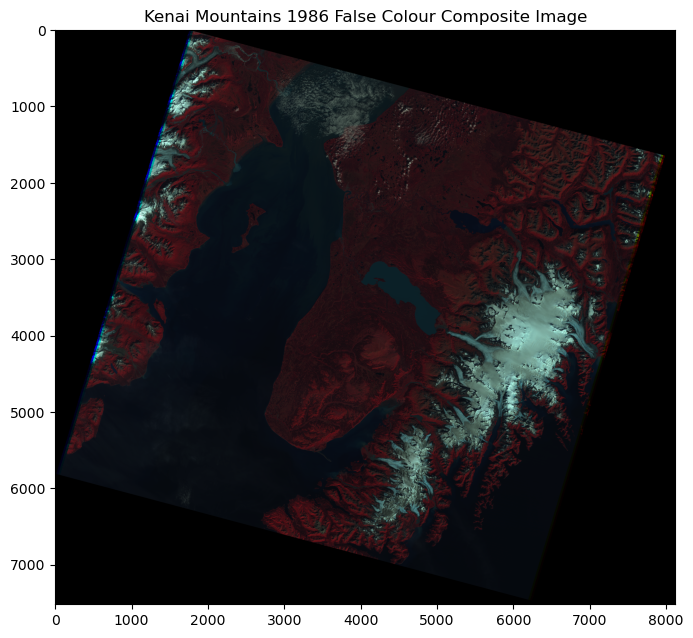

In [62]:
# In this cell we will build the False Colour Composite image of the 1986 Landsat scene
# The bands we are going to need are B4, B3 and B2 (NIR, Red and Green respectively)
# After we build the Landsat scene we are going to save the new image to the 'KenaiMountains1986' folder

#First we are going to use the rasterio module to open the paths to the Band TIF files in the folder they are saved to
with rasterio.open("KenaiMountains1986/LT05_L1TP_069018_19860912_20200917_02_T1_B4.TIF") as KM1986_B4IMG:
    KM86B4 = KM1986_B4IMG.read(1)
with rasterio.open("KenaiMountains1986/LT05_L1TP_069018_19860912_20200917_02_T1_B3.TIF") as KM1986_B3IMG:
    KM86B3 = KM1986_B3IMG.read(1)
with rasterio.open("KenaiMountains1986/LT05_L1TP_069018_19860912_20200917_02_T1_B2.TIF") as KM1986_B2IMG:
    KM86B2 = KM1986_B2IMG.read(1)

# We will stack the newly defined bands using the NumPy module to create a single 3D Array
KM1986_falsecolourstack = np.dstack((KM86B4, KM86B3, KM86B2))

# Then the created 3D array will be printed to show the False Colour Composite image of the selected Landsat scene for 1986
plt.figure(figsize=(8, 8))
plt.imshow(KM1986_falsecolourstack)
plt.title("Kenai Mountains 1986 False Colour Composite Image")
plt.show()

In [63]:
# Now that the False Colour Composite Image has been created, we will need to save the image  

# First we will open one of the bands to get its profile and use it as a source
with rasterio.open("KenaiMountains1986/LT05_L1TP_069018_19860912_20200917_02_T1_B4.TIF") as KM1986_source:
    KM1986_ImgProfile = KM1986_source.profile

# We then update the profile for all of the bands in the False Colour Composite using the source
KM1986_ImgProfile.update(
    count=3,  # The count is set to 3 as we are using 3 bands (NIR, Red and Green)
    dtype=KM1986_falsecolourstack.dtype  # We set that data type to be the same as the created False Colour Composite
)

# Finally we save the False Colour Composite to the Kenai Mountains folder
with rasterio.open('KenaiMountains1986/KM1986_FullFCC.TIF', 'w', **KM1986_ImgProfile) as KM1986_FCCdownload:
# We then use the .write function to save the False Colour image to the Kenai Mountains 1986 folder
# We use .transpose to chnage the shape of the array to match the format expected by rasterio when writing/saving the image to the folder (Bands, Rows and Columns respectively) 
    KM1986_FCCdownload.write(KM1986_falsecolourstack.transpose(2, 0, 1))  
print("Image has been saved as KM1986_FullFCC.TIF in KenaiMountains1986")

Image has been saved as KM1986_FullFCC.TIF in KenaiMountains1986


In [65]:
# The KenaiMountains1986 folder is rather full and messy so we will delete all the unneccessary files that we no longer need
# The only file we need from here on is the exported False Colour Composite so the rest can be deleted to make the GitHub commits easier
# This will be useful when it comes to using more modern Landsat datasets as the files will be over 100mb which causes issues in the GitHub commit

for KM1986_filenames in os.listdir('KenaiMountains1986'): 
    KM1986_FilePath = os.path.join('KenaiMountains1986', KM1986_filenames) # We create a variable that loops through all of the filenames in the KenaiMountains1986 folder
    
    if os.path.isfile(KM1986_FilePath) and KM1986_filenames != 'KM1986_FullFCC.TIF':
        os.remove(KM1986_FilePath)
print("Deleted the files that are no longer required (Click Refresh on folder)")

Deleted the files that are no longer required (Click Refresh on folder)


Now that we have downloaded the False Colour Composite image for the Kenai Mountains in 1986, the next step is produce a supervised classification that selects glacier snow and ice

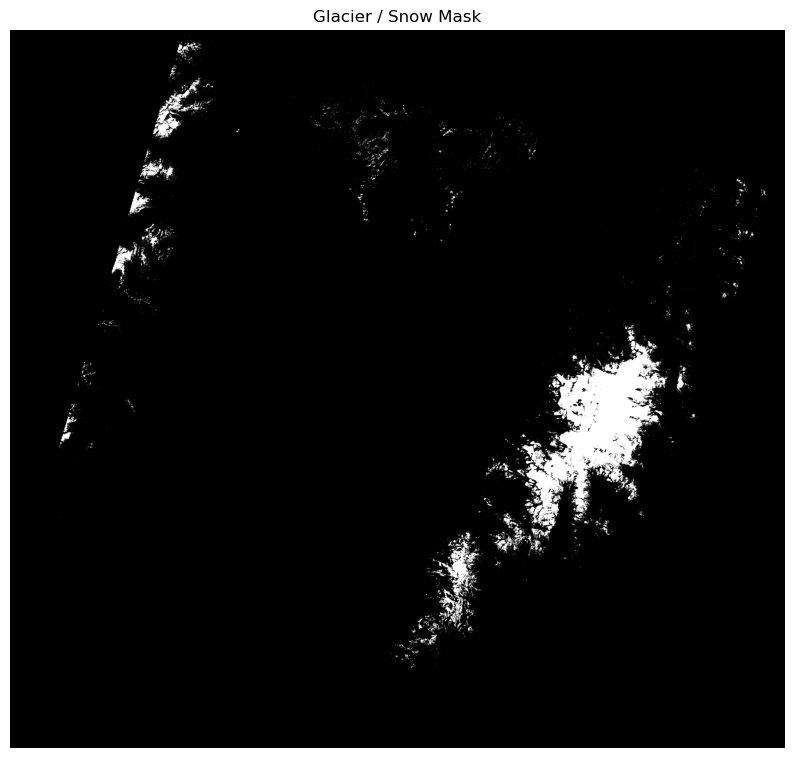

In [79]:
#First we will open the TIF
with rasterio.open('KenaiMountains1986/KM1986_FullFCC.TIF') as KM1986FCCsrc:
    KM1986_Normalised = KM1986FCCsrc.read()
    KM1986_profile = KM1986FCCsrc.profile

# The Landsat bands are Digitial Numbers so we then will normalize bands from 0-255 (as they are an 8-bit image) to 0-1
KM1986_Normalised = KM1986_Normalised.astype(np.float32)
KM1986_Normalised /= KM1986_Normalised.max()

KM1986_Glacier = (KM1986_Normalised[0] > 0.3) & (KM1986_Normalised[1] > 0.3) & (KM1986_Normalised[2] > 0.3)

plt.figure(figsize=(8, 8))
plt.imshow(KM1986_Glacier, cmap='gray')
plt.title('Kenai Mountains 1986 - Supervised classification of Glacier snow and ice')
plt.show()


In [82]:
with rasterio.open('KenaiMountains1986/KM1986_FullFCC.TIF') as KM1986FCCsrc:
    print(KM1986FCCsrc.bounds)

BoundingBox(left=481185.0, bottom=6551985.0, right=724815.0, top=6777615.0)


In [ ]:
help(requests.get)

In [ ]:
api.download_options(
    dataset="landsat_tm_c2_l1",
    entity_ids="LT50690181986255XXX05"
)


In [66]:
# Logs out the existing USGS account for the script
api.logout()

{'requestId': 1986444705,
 'version': 'stable',
 'sessionId': 315132629,
 'data': None,
 'errorCode': None,
 'errorMessage': None}